In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
#environment imports 
#load libraries 
import pandas as pd
import numpy as np
''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config

set_config(display='diagram')
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import confusion_matrix
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image

from os import listdir
from os.path import isdir, join
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#load data 
print(listdir()[1])
data = pd.read_csv('/content/drive/MyDrive/Financial_Sentiment_Analysis_LSTM_GRU/Financial_Sentiment_Analysis_LSTM_GRU/data/data.csv')

drive


In [ ]:
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
data.describe(include='all')

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [ ]:
#count of the sentiment categories
print('count of Sentiment catagories :','\n', data.Sentiment.value_counts() ,'\n',
      'proportion of the Sentiment categories:','\n', data.Sentiment.value_counts(normalize=True))

count of Sentiment catagories : 
 neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64 
 proportion of the Sentiment categories: 
 neutral     0.535775
positive    0.317015
negative    0.147210
Name: Sentiment, dtype: float64


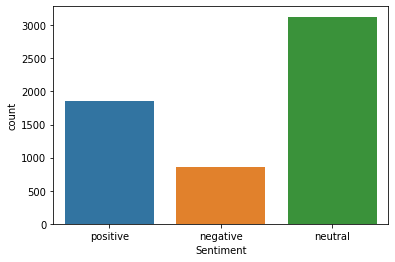

In [ ]:
#labels distribution 
sns.countplot(data.Sentiment)

In [ ]:
#overview of the Sentences state
import random
for i in range(5):
  print(data.Sentence[i])

The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
$ESI on lows, down $1.50 to $2.50 BK a real possibility
For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .
The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .


In [ ]:
#mapping int into labels 
dictionary ={'positive':1,'neutral':0, 'negative':-1}
data.Sentiment = data.Sentiment.map(dictionary)

# Text Preprocessing 

In [ ]:
# Text preprocessing imports 
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
import string
import re

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. 
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text.  
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [ ]:
df = data.copy()
df.Sentence = df.Sentence.apply(clean_text)

In [ ]:
df.Sentence[6]

'shells 70 billion bg deal meets shareholder skepticism'

# Model Architecture

In [ ]:
# Tensoflow text vectorizer imports 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#Tokenize Sentences
X= df.Sentence
y= df.Sentiment

#intitialize Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
    
# Apply tokenization to the train and test set
X_token= tokenizer.texts_to_sequences(X)


In [ ]:
#Print some of the tokenized sentences 
sentence_number = 100

input_raw = X[sentence_number]
input_token = X_token[sentence_number]

for i in range(10):
    print(f'word : {input_raw[i]} -> Token {input_token[i]}')

word : h -> Token 4019
word : a -> Token 4020
word : r -> Token 6115
word : g -> Token 601
word : r -> Token 122
word : e -> Token 331
word : a -> Token 602
word : v -> Token 390
word : e -> Token 361
word : s -> Token 41


In [ ]:
#vocab size
vocab_size = len(tokenizer.word_index)
print(f'There are {vocab_size} unique words')

There are 12451 unique words


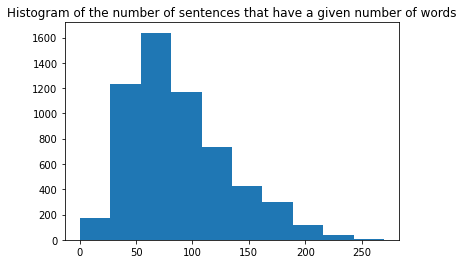

In [ ]:
def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()
    
plot_hist(X)

In [ ]:
#padding 
X_pad = pad_sequences(X_token, dtype='float32', padding='post', maxlen=200)

In [ ]:
#labels to catgorical 
y_cat = to_categorical(y, 3)
print(y_cat)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [ ]:
#train test split 

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4673, 200) (4673, 3)
(1169, 200) (1169, 3)


In [ ]:
embedding_dimension= 100
def model_init():
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size +1 , output_dim = embedding_dimension, mask_zero=True , input_length=X_train.shape[1]))
  model.add(SpatialDropout1D(0.5))
  model.add(LSTM(512, return_sequences=True))
  model.add(GRU(512, return_sequences=False))
  model.add(Dropout(rate=0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(38, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
print(f'Expected number of parameters : {(vocab_size + 1) * embedding_dimension}')

Expected number of parameters : 1245200


In [ ]:
model= model_init()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 100)          1245200   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 200, 512)          1255424   
                                                                 
 gru_4 (GRU)                 (None, 512)               1575936   
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                      

In [ ]:
#fit model 
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=5,
                   restore_best_weights=True)

history = model.fit(X_train, y_train,
                    batch_size = 64,
                    epochs = 20,
                    validation_split=0.1,
                    callbacks =[es]
                    )

Epoch 1/20
66/66 [==============================] - 18s 121ms/step - loss: 1.0244 - accuracy: 0.5023 - val_loss: 0.9843 - val_accuracy: 0.5342
Epoch 2/20
66/66 [==============================] - 5s 73ms/step - loss: 0.9078 - accuracy: 0.5465 - val_loss: 0.8942 - val_accuracy: 0.5940
Epoch 3/20
66/66 [==============================] - 5s 70ms/step - loss: 0.7902 - accuracy: 0.6480 - val_loss: 0.8936 - val_accuracy: 0.5791
Epoch 4/20
66/66 [==============================] - 5s 70ms/step - loss: 0.7091 - accuracy: 0.7068 - val_loss: 1.0086 - val_accuracy: 0.5812
Epoch 5/20
66/66 [==============================] - 5s 71ms/step - loss: 0.6317 - accuracy: 0.7522 - val_loss: 0.9468 - val_accuracy: 0.6175
Epoch 6/20
66/66 [==============================] - 5s 71ms/step - loss: 0.5417 - accuracy: 0.7853 - val_loss: 0.9077 - val_accuracy: 0.6816
Epoch 7/20
66/66 [==============================] - 5s 71ms/step - loss: 0.4347 - accuracy: 0.8150 - val_loss: 1.1344 - val_accuracy: 0.6709
Epoch 8/20


In [ ]:
#baseline model 
sum_ = np.sum(y_train, axis=0)
predicted_category = np.argmax(sum_)

good_prediction = np.sum(y_test, axis=0)[predicted_category]
baseline_result = good_prediction/len(y_test)

print(f'Baseline accuracy: {baseline_result}')

Baseline accuracy: 0.5355004277159966


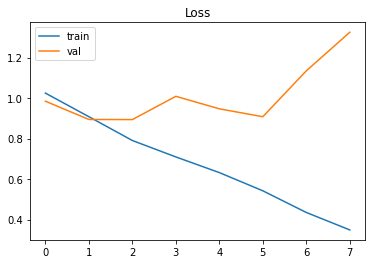

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

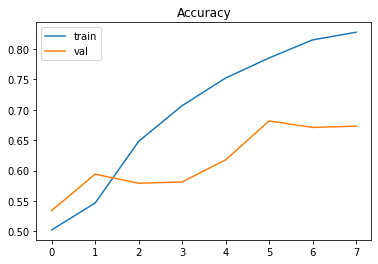

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [ ]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 1s 19ms/step - loss: 0.9597 - accuracy: 0.5902


[0.9597012400627136, 0.5902480483055115]

# Next steps: 




1.   Embedding using word2Vec
2.   Transfer learning
3.   Use CNN for this task 




